Imports


In [1]:
# Install haversine if required
#!pip install haversine

# Import necessary libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
import geopy.distance
import haversine as hs
from haversine import Unit
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import seaborn as sns
from tkinter import filedialog

Load data


In [2]:
# Load dataset
file_path = filedialog.askopenfilename(title="Select the CSV file")

df = pd.read_csv(file_path)


Drop column 1 and 2

In [3]:
# Remove unnecessary columns
df.drop(['key'], axis=1, inplace=True)
df.dropna(axis=0,inplace=True)

In [4]:
# Check for missing values
print("\nMissing values in the dataset:")
print(df.isnull().sum())



Missing values in the dataset:
fare_amount          0
pickup_datetime      0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
passenger_count      0
dtype: int64


In [5]:
# Display the first few rows of the dataset
print("First few rows of the dataset:")
print(df.head())

print('\r\n')

# Display the columns of the dataset
print("Fields of the dataset:")
print(df.columns)

First few rows of the dataset:
   fare_amount          pickup_datetime  pickup_longitude  pickup_latitude  \
0          4.5  2009-06-15 17:26:21 UTC        -73.844311        40.721319   
1         16.9  2010-01-05 16:52:16 UTC        -74.016048        40.711303   
2          5.7  2011-08-18 00:35:00 UTC        -73.982738        40.761270   
3          7.7  2012-04-21 04:30:42 UTC        -73.987130        40.733143   
4          5.3  2010-03-09 07:51:00 UTC        -73.968095        40.768008   

   dropoff_longitude  dropoff_latitude  passenger_count  
0         -73.841610         40.712278                1  
1         -73.979268         40.782004                1  
2         -73.991242         40.750562                2  
3         -73.991567         40.758092                1  
4         -73.956655         40.783762                1  


Fields of the dataset:
Index(['fare_amount', 'pickup_datetime', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude',

Extract hours from date time

In [6]:
# Convert 'pickup_datetime' to a datetime data type
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Extract the date, time, and other components
df['Hour'] = df['pickup_datetime'].dt.hour


In [7]:
df.drop('pickup_datetime', axis=1, inplace=True)



Remove latitude and longitude values not in range

In [8]:
#Drop the rows where the latitude and longitude are not in range
condition = df[
    (df['pickup_longitude'] < -180) | (df['pickup_longitude'] > 180) |
    (df['pickup_latitude'] < -90) | (df['pickup_latitude'] > 90) |
    (df['dropoff_longitude'] < -180) | (df['dropoff_longitude'] > 180) |
    (df['dropoff_latitude'] < -90) | (df['dropoff_latitude'] > 90)
].index
df.drop(condition, inplace=True)

Calculate Distance

In [9]:
#Calculate the distance between pickup and dropoffm
longitude, latitude = [], []

longitude.append(df["pickup_longitude"].tolist())
longitude.append(df["dropoff_longitude"].tolist())
latitude.append(df["pickup_latitude"].tolist())
latitude.append(df["dropoff_latitude"].tolist())

#Find the distance in miles
distance = [hs.haversine((latitude[1][i], longitude[1][i]), (latitude[0][i], longitude[0][i]), unit=Unit.KILOMETERS)
              for i in range(len(longitude[0]))]

#Append the new distance column to the dataset
df['distance'] = distance

In [10]:

df.drop(['pickup_longitude', 'pickup_latitude','dropoff_longitude', 'dropoff_latitude'] , inplace=True , axis= 1)
df.head()

,fare_amount,passenger_count,Hour,distance
0,4.5,1,17,1.030765
1,16.9,1,16,8.450145
2,5.7,2,0,1.389527
3,7.7,1,4,2.799274
4,5.3,1,7,1.999160


Remove Outliers

In [11]:
#Drop the rows where the fare amount is <=0 and distance is <=0

df.drop(df[df['fare_amount']<=0].index,inplace=True)
df.drop(df[df['distance']<=0].index,inplace=True)
df.drop(df[df['distance']>60].index,inplace=True)

#drop outlier distance and fair amount
df.drop(df[df['distance']>100].index,inplace=True)
df.drop(df[df['fare_amount']>100].index,inplace=True)

#drop unrealistic fair amounts and distance travelled
df.drop(df[(df['fare_amount']>=100) & (df['distance']<=1)].index,inplace=True)
df.drop(df[(df['fare_amount']<=100) & (df['distance']>=100)].index,inplace=True)


Distance vs fare amount graph

Text(0, 0.5, 'fare_amount')

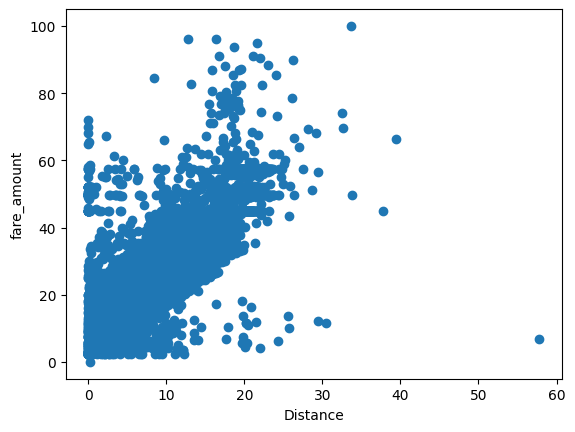

In [12]:
plt.scatter(df['distance'], df['fare_amount'])
plt.xlabel("Distance")
plt.ylabel("fare_amount")

In [13]:
x = df.drop(['fare_amount'],axis = 1)
y = df['fare_amount'].values.reshape(-1, 1)

In [14]:
from sklearn.preprocessing import StandardScaler

std = StandardScaler()

Standardize values

In [15]:
y_std = std.fit_transform(y)

x_std = std.fit_transform(x)

In [16]:
# Model Evaluation
x_train, x_test, y_train, y_test = train_test_split(x_std, y_std, test_size=0.2, random_state=42)

Linear Regression


In [17]:
# Create linear model and train
from sklearn.linear_model import LinearRegression
LR = LinearRegression()
LR.fit(x_train,y_train)

LR_y_predict = LR.predict(x_test)

Linear Regression Accuracy


In [18]:

# Calculate regression metrics
mse = mean_squared_error(y_test, LR_y_predict)
mae = mean_absolute_error(y_test, LR_y_predict)
r2 = r2_score(y_test, LR_y_predict)
rmse = np.sqrt(mse)

print("Linear Regression Mean Squared Error:", mse)


print("Linear Regression Root Mean Squared Error:", rmse)

print("Linear Regression Mean Absolute Error:", mae)
print("Linear Regression R-squared:", r2)



Linear Regression Mean Squared Error: 0.21611637248025617
Linear Regression Root Mean Squared Error: 0.4648831815416172
Linear Regression Mean Absolute Error: 0.25174746773237194
Linear Regression R-squared: 0.7862718481826971


Random Forest

In [19]:
from sklearn.ensemble import RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

rf_regressor.fit(x_train, y_train.ravel())
# Make predictions on the test set
RF_y_pred = rf_regressor.predict(x_test)

In [20]:
# Calculate regression metrics
mse = mean_squared_error(y_test, RF_y_pred)
mae = mean_absolute_error(y_test, RF_y_pred)
r2 = r2_score(y_test, RF_y_pred)
rmse = np.sqrt(mse)

print("Random Forest Mean Squared Error:", mse)


print("Random Forest Root Mean Squared Error:", rmse)

print("Random Forest Mean Absolute Error:", mae)
print("Random Forest R-squared:", r2)


Random Forest Mean Squared Error: 0.22737760120951495
Random Forest Root Mean Squared Error: 0.4768412746496626
Random Forest Mean Absolute Error: 0.2695676563789274
Random Forest R-squared: 0.775135063052194


Gradiant Boosting Regression

In [21]:
from sklearn.ensemble import GradientBoostingRegressor
gb_regressor = GradientBoostingRegressor(n_estimators=100, max_depth=3, random_state=42)

# Train the model
gb_regressor.fit(x_train, y_train.ravel())

# Make predictions on the test set
GB_y_pred = gb_regressor.predict(x_test)

In [22]:
# Calculate regression metrics
mse = mean_squared_error(y_test, GB_y_pred)
mae = mean_absolute_error(y_test, GB_y_pred)
r2 = r2_score(y_test, GB_y_pred)
rmse = np.sqrt(mse)

print("Gradiant Boosting Mean Squared Error:", mse)


print("Gradiant Boosting Root Mean Squared Error:", rmse)

print("Gradiant Boosting Mean Absolute Error:", mae)
print("Gradiant Boosting R-squared:", r2)



Gradiant Boosting Mean Squared Error: 0.18972277785166933
Gradiant Boosting Root Mean Squared Error: 0.4355717826623636
Gradiant Boosting Mean Absolute Error: 0.2400763555437842
Gradiant Boosting R-squared: 0.8123737771344165


In [23]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier



# Create a dictionary with all predictions
df = {'Actual': y_test, 'Predicted (LR)': LR_y_predict, 'Predicted (RF)': RF_y_pred, 'Predicted (GB)': GB_y_pred}

# Print the tabulated results
from tabulate import tabulate
print(tabulate(df, headers='keys', tablefmt='psql'))

+-------------+------------------+------------------+------------------+
|      Actual |   Predicted (LR) |   Predicted (RF) |   Predicted (GB) |
|-------------+------------------+------------------+------------------|
| -0.260535   |     -0.19088     |     -0.137751    |     -0.165882    |
|  0.339981   |      0.18926     |      0.184415    |      0.236626    |
|  0.554451   |      0.032722    |      0.0241736   |      0.0942033   |
|  1.54101    |      1.47495     |      1.4435      |      1.86025     |
| -0.174747   |     -0.481461    |     -0.572696    |     -0.462582    |
| -0.678752   |     -0.557042    |     -0.582884    |     -0.552406    |
|  0.286363   |      0.383363    |      0.165509    |      0.216669    |
|  0.589838   |     -0.23475     |     -0.405088    |     -0.252046    |
| -0.0353418  |     -0.255961    |     -0.204773    |     -0.212209    |
|  0.382875   |      0.514555    |      0.67391     |      0.386719    |
| -0.346323   |     -0.195844    |     -0.199197   

Actual vs Predicted

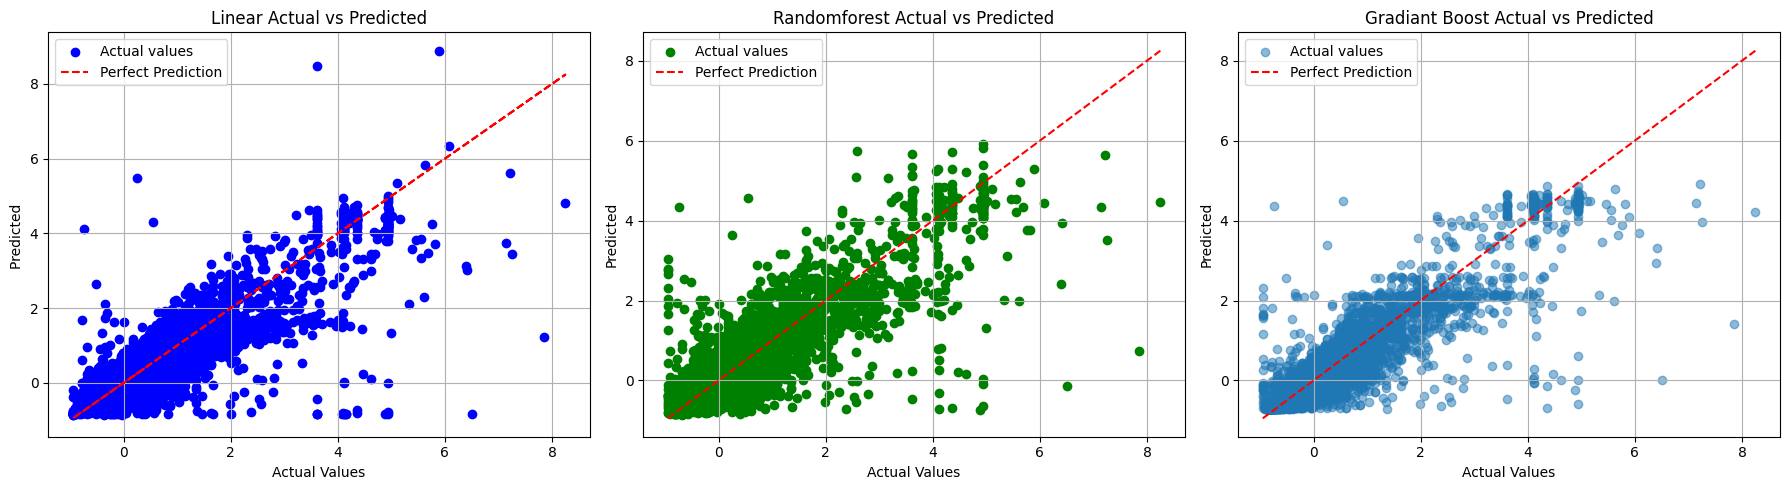

In [24]:
import matplotlib.pyplot as plt

# Create a figure with three subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 5))

# Actual vs. Predicted scatter plot
ax1.scatter(y_test, LR_y_predict, color='blue', label='Actual values')
ax1.plot(y_test, y_test, color='red', linestyle='--', label='Perfect Prediction')
ax1.set_xlabel('Actual Values')
ax1.set_ylabel('Predicted ')
ax1.set_title('Linear Actual vs Predicted')
ax1.legend()
ax1.grid(True)

# Residuals plot
ax2.scatter(y_test, RF_y_pred, color='green', label='Actual values')
ax2.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
ax2.set_xlabel('Actual Values')
ax2.set_ylabel('Predicted')
ax2.set_title('Randomforest Actual vs Predicted')
ax2.legend()
ax2.grid(True)

# Histogram of residuals
ax3.scatter(y_test, GB_y_pred, alpha=0.5, label='Actual values')
ax3.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', label='Perfect Prediction')
ax3.set_xlabel('Actual Values')
ax3.set_ylabel('Predicted')
ax3.set_title('Gradiant Boost Actual vs Predicted')
ax3.legend()
ax3.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import numpy as np

# Assuming you have your feature matrix X and target variable y
y_train=y_train.ravel()
# Linear Regression
lr = LinearRegression()
lr_scores = cross_val_score(lr, x_train, y_train, cv=5)
lr_mean_accuracy = lr_scores.mean()
print("Linear reg Cross-Validation Accuracy:", lr_mean_accuracy)

rf = RandomForestRegressor()
rf_score = cross_val_score(rf, x_train, y_train, cv=5)
rf_mean_accuracy = rf_score.mean()
print("Random Forest Cross-Validation Accuracy:", rf_mean_accuracy)

gb = GradientBoostingRegressor()
gb_score = cross_val_score(rf, x_train, y_train, cv=5)
gb_mean_accuracy = gb_score.mean()
print("Gradiant Boosting Cross-Validation Accuracy:", gb_mean_accuracy)
